I am analyzing, primarily using regression, the effect of several factors on the price of a car. My
objective is to determine the features of most significance to predicting the price of a car

In [70]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
import os
# Required for modeling and evaluation
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from scipy.optimize import minimize
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from typing import Callable

In [71]:
#data stored in CarPrices.csv
input_data = pd.read_csv('CarPrices.csv', delimiter = ',')
#price is the target variable
price=np.array(input_data.price)
#one-hot encoding is used here to turn categorical variables into separate columns.
encoder = OneHotEncoder(sparse_output=False)
fueltype_binary = input_data.fueltype.map({'gas': 0, 'diesel': 1})
fueltype_encoded = encoder.fit_transform(fueltype_binary.values.reshape(-1,1))
door_binary = input_data.doornumber.map({'two': 0, 'four': 1})
door_encoded = encoder.fit_transform(door_binary.values.reshape(-1,1))
carbody_numeric = input_data.carbody.map({'convertible': 0, 'hatchback': 1,
                                          'sedan': 2, 'hardtop': 3})
carbody_encoded = encoder.fit_transform(carbody_numeric.values.reshape(-1,1))
drivewheel_numeric = input_data.drivewheel.map({'rwd': 0, 'fwd': 1, '4wd': 2})
drivewheel_encoded = encoder.fit_transform(drivewheel_numeric.values.reshape(-1,1))
#forming a DataFrame for use in train_test_split
x=pd.DataFrame({'gas': fueltype_encoded[:, 0], 'diesel': fueltype_encoded[:, 1],
                'twodoor': door_encoded[:, 0], 'fourdoor': door_encoded[:, 1], 
                'convertible': carbody_encoded[:, 0], 'hatchback': carbody_encoded[:, 1],
                'sedan': carbody_encoded[:, 2], 'wagon': carbody_encoded[:, 4],
                'hardtop': carbody_encoded[:, 3], 'rwd': drivewheel_encoded[:, 0],
                'fwd': drivewheel_encoded[:, 1], '4wd': drivewheel_encoded[:, 2], 
               'enginesize': input_data['enginesize'], 'horsepower': input_data['horsepower'],
                'citympg': input_data['citympg'], 'highwaympg': input_data['highwaympg']})

#making the price into a dataframe.
price_df=pd.DataFrame(price)

This dataset contains several predictors for the price of a new car. The dataset contains: Price, the target variable, in dollars

Fuel type, which may be gas or diesel

Number of doors, which may be two or four (I treated this as a categorical variable rather than a numeric one because there were two values)

Car body type, which may be convertible, hatchback, sedan, wagon or hardtop

Drive type, which may be rear-wheel drive (rwd), front-wheel drive (fwd) or four-wheel drive (4wd)

There is also engine size in cubic inches, horsepower in HP and fuel efficiency in miles per gallon for both city and highway driving.

There are 205 data points in the set I'm checking for correlated variables.

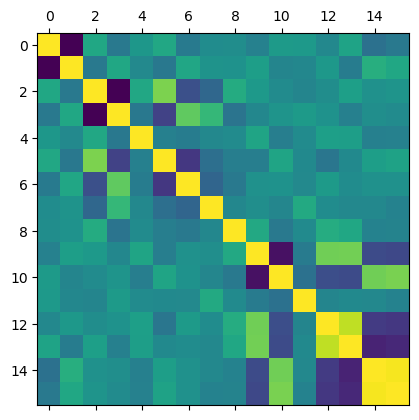

In [4]:
plt.matshow(x.corr())
plt.show()

Highway MPG and city MPG are strongly correlated, as are engine size and horespower.
Horsepower and citympg are also correlated and so I'll remove citympg as well. The fuel efficiencies matching is expected, as are engine size and horsepower; horsepower and fuel efficiency are also naturally linked but less directly. Finally, each of the one-hot encoded portions have a redundant column so I'll get rid of one of those too.

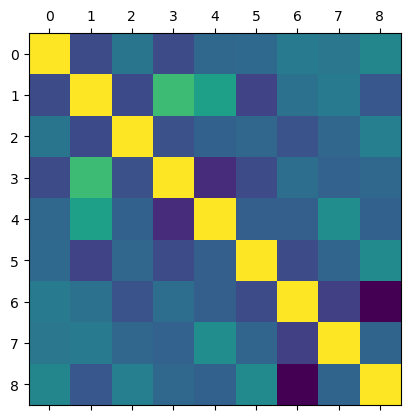

In [5]:
x_pruned=x.drop(['highwaympg', 'enginesize', 'citympg', 'diesel', 'twodoor', 'hatchback', 'rwd'], axis=1)
plt.matshow(x_pruned.corr())
plt.show()

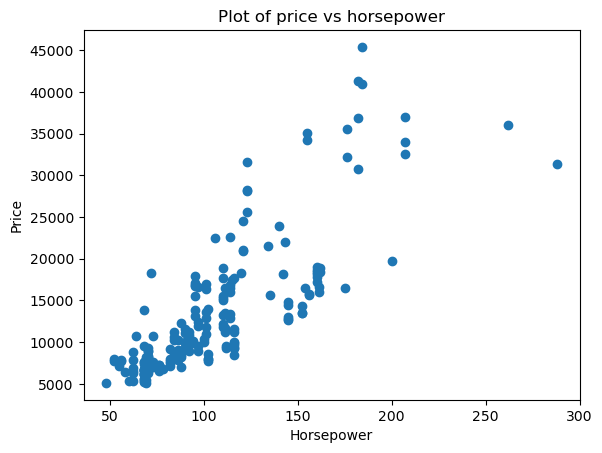

In [6]:
plt.scatter(x_pruned['horsepower'],price)
plt.title('Plot of price vs horsepower')
plt.xlabel('Horsepower')
plt.ylabel('Price')
plt.show()

This is the one non-correlated numerical value remaining, and the relationship looks approximately linear, but possibly with some heteroskedasticity, suggesting that a linear model may be appropriate. Below are the plots of the remaining features.

In [7]:
#counts of each categorical variable
gasno=np.sum(x_pruned['gas'])
dieselno=np.sum(x['diesel'])
twodoorno=np.sum(x['twodoor'])
fourdoorno=np.sum(x_pruned['fourdoor'])
convertibleno=np.sum(x_pruned['convertible'])
hatchbackno=np.sum(x['hatchback'])
sedanno=np.sum(x_pruned['sedan'])
wagonno=np.sum(x_pruned['wagon'])
hardtopno=np.sum(x_pruned['hardtop'])
rwdno=np.sum(x['rwd'])
fwdno=np.sum(x_pruned['fwd'])
fourwdno=np.sum(x_pruned['4wd'])
#setting up lists for the bar charts
doors = ['two doors', 'four doors']
doorvals = [twodoorno, fourdoorno]
fuels = ['gas', 'diesel']
fuelvals = [gasno, dieselno]
body = ['convertible', 'hatchback', 'sedan', 'wagon', 'hardtop']
bodyvals = [convertibleno, hatchbackno, sedanno, wagonno, hardtopno]

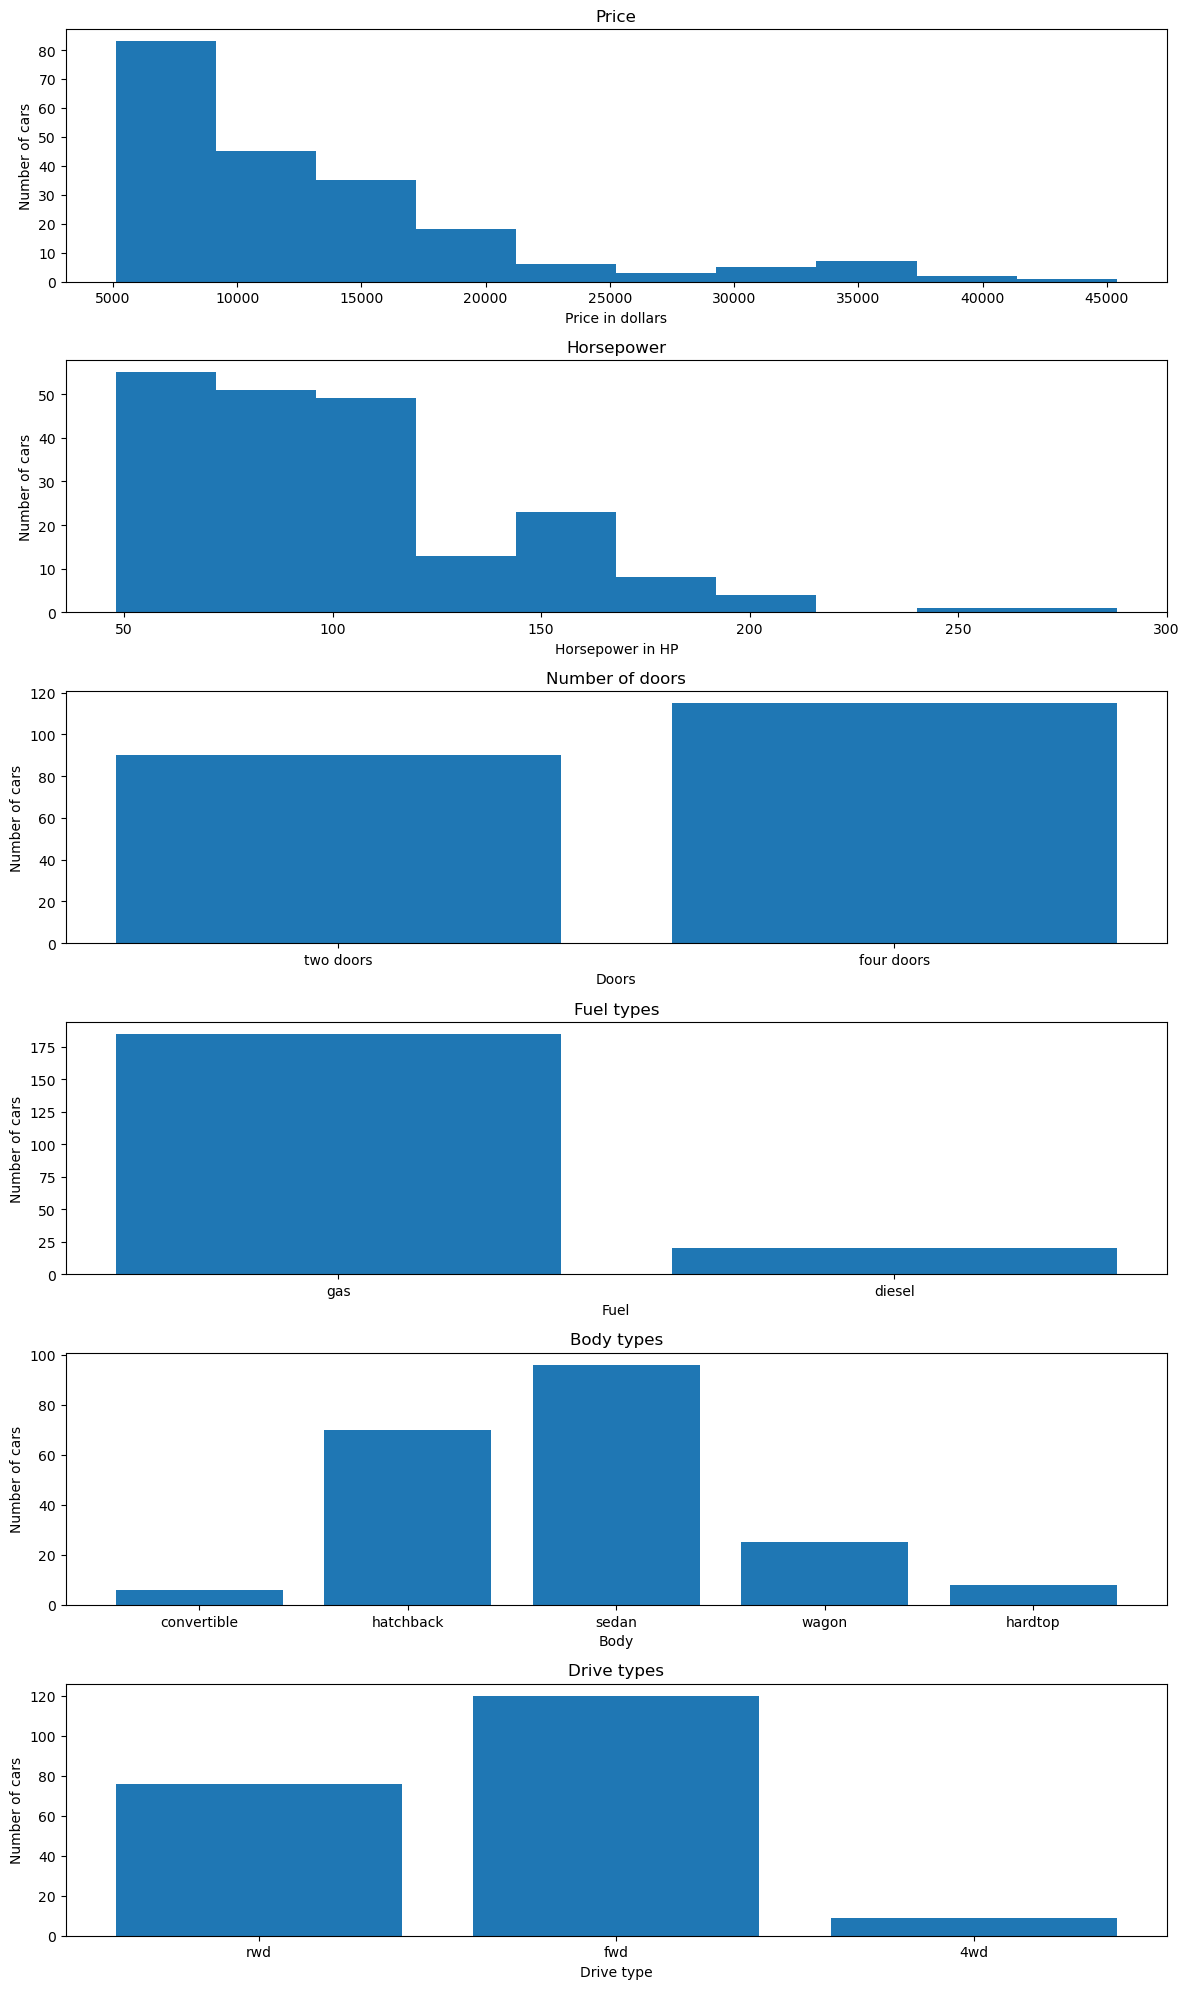

In [8]:
drive = ['rwd', 'fwd', '4wd']
drivevals = [rwdno, fwdno, fourwdno]
#lots of bar plots
fig, axs = plt.subplots(6, 1, figsize = (12,20))
axs[0].hist(price_df)
axs[0].set_title('Price')
axs[0].set_xlabel('Price in dollars')
axs[0].set_ylabel('Number of cars')

axs[1].hist(x_pruned['horsepower'])
axs[1].set_title('Horsepower')
axs[1].set_xlabel('Horsepower in HP')
axs[1].set_ylabel('Number of cars')

axs[2].bar(doors, doorvals)
axs[2].set_title('Number of doors')
axs[2].set_xlabel('Doors')
axs[2].set_ylabel('Number of cars')

axs[3].bar(fuels, fuelvals)
axs[3].set_title('Fuel types')
axs[3].set_xlabel('Fuel')
axs[3].set_ylabel('Number of cars')

axs[4].bar(body, bodyvals)
axs[4].set_xlabel('Body')
axs[4].set_ylabel('Number of cars')
axs[4].set_title('Body types')

axs[5].bar(drive, drivevals)
axs[5].set_title('Drive types') 
axs[5].set_xlabel('Drive type')
axs[5].set_ylabel('Number of cars')

plt.tight_layout()
plt.show()

In [9]:
numcars=len(x_pruned)
fuelprop=np.array(fuelvals)/numcars
print(f'Gas comprises {fuelprop[0]*100:.1f}% of vehicles, with diesel making up the remainder.')
doorprop=np.array(doorvals)/numcars
print(f'Two door vehicles comprise {doorprop[0]*100:.1f}% of vehicles, with the remainder comprised of four door vehicles.')

bodyprop=np.array(bodyvals)/numcars
print(f'Convertibles comprise {bodyprop[0]*100:.1f}% of vehicles, hatchbacks comprise {bodyprop[1]*100:.1f}% of vehicles,'
f'sedans comprise {bodyprop[2]*100:.1f}% of vehicles, wagons comprise {bodyprop[3]*100:.1f}% and hardtops comprise'
f'{bodyprop[4]*100:.1f}% of vehicles. The approximately normal appearance of the graph is a coincidence relating to ordering choice.')
driveprop=np.array(drivevals)/numcars
print(f'Rear-wheel drive vehicles comprise {driveprop[0]*100:.1f}% of vehicles, front-wheel drive vehicles comprise {driveprop[1]*100:.1f}% and 4wd comprises the remaining {driveprop[2]*100:.1f}%.')
print(f'The average price is ${np.mean(price_df):.2f} with a minimum of ${np.min(price)}, a maximum of ${np.max(price)} and a standard deviation of ${np.std(price_df,axis=0)[0]:.2f}. It is heavily asymmetric, skewed to the right.')
print(f'The average horsepower is {np.mean(x_pruned['horsepower']):.0f} HP with a minimum of {np.min(x_pruned['horsepower'])}'
f'HP, a maximum of {np.max(x_pruned['horsepower'])} HP and a standard deviation of {np.std(x_pruned['horsepower'])}) HP with a right skew.')


Gas comprises 90.2% of vehicles, with diesel making up the remainder.
Two door vehicles comprise 43.9% of vehicles, with the remainder comprised of four door vehicles.
Convertibles comprise 2.9% of vehicles, hatchbacks comprise 34.1% of vehicles,sedans comprise 46.8% of vehicles, wagons comprise 12.2% and hardtops comrpise3.9% of vehicles. The approximately normal appearance of the graph is a coincidence relating to ordering choice.
Rear-wheel drive vehicles comprise 37.1% of vehicles, front-wheel drive vehicles comprise 58.5% and 4wd comprises the remaining 4.4%.
The average price is $13276.71 with a minimum of $5118.0, a maximum of $45400.0 and a standard deviation of $7969.34. It is heavily asymmetric, skewed to the right.
The average horsepower is 104 HP with a minimum of 48HP, a maximum of 288 HP and a standard deviation of 39.44759971330306) HP with a right skew.


In [33]:
#this two-step process makes a 60% training split, a 20% validation split, and a 20% test set
X_train, X_temp, Y_train, Y_temp = train_test_split(x_pruned, price_df, test_size=0.4, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)
#I will scale the data as this helps many models
scaler = StandardScaler()
#Converting everything to the required forms, including some dataframes and some arrays
X_train = pd.DataFrame(X_train, columns=x_pruned.columns)
X_val = pd.DataFrame(X_val, columns=x_pruned.columns)
X_test = pd.DataFrame(X_test, columns=x_pruned.columns)
X_test_array=np.array(X_test)
X_train_val=pd.concat([X_train, X_val])
X_train_val_array=np.array(X_train_val)
Y_train_val=pd.concat([Y_train, Y_val])
#Sometimes a 1D array is needed
Y_train_array=np.array(Y_train).ravel()
Y_train_val_array=np.array(Y_train_val).ravel()

#There are 9 features in the model
n_features=9

I evaluate several models in terms of AIC and BIC, defined here, although my overall metric throughout, largely because of its universal applicability, is root mean squared error. RMSE is appealing because it can be applied to any model and the root helps manage extreme values, which are known to be present due to the skewed price distribution.

In [11]:
#Not my code
def calculate_aic(y:np.ndarray, y_pred:np.ndarray,
                  num_params:int) -> float:
    """
    Calculate AIC (Akaike Information Criterion) for a least squares regression
    """
    if len(y) != len(y_pred):
        raise ValueError("Input arrays y and y_pred must have the same length.")
    n = len(y)
    residual_error = np.array(y) - np.array(y_pred)
    rss = np.mean(residual_error ** 2)
    aic = n * np.log(rss) + 2 * num_params
    return aic

In [12]:
#Not my code
def calculate_bic(y:np.ndarray, y_pred:np.ndarray,
                  num_params:int) -> float:
    """
    Calculate BIC (Bayesian Information Criterion) for a least squares regression
    """
    if len(y) != len(y_pred):
        raise ValueError("Input arrays y and y_pred must have the same length.")
    n = len(y)
    residual_error = np.array(y) - np.array(y_pred)
    rss = np.sum(residual_error ** 2)
    bic = n * np.log(rss) + num_params * np.log(n)
    return bic

For my first model, I am using a sequential feature selection linear model. This is designed to manage model complexity by only adding significant factors, making it an appealing simple model.

In [47]:
# Using linear regression
modelSFS=LinearRegression()

# Using sci-kit learn's sequential feature selector to choose variables with R-squar
sfs = SequentialFeatureSelector(modelSFS,
    n_features_to_select='auto',
    direction="forward",
    scoring="neg_root_mean_squared_error",
    cv=5,
    tol=0.01)

#Fit the model
sfs.fit(X_train, Y_train)

#Get selected features and print them out
selected_features_mask = sfs.get_support()
selected_features_names = X_train.columns[selected_features_mask] if hasattr(X_train, 'columns') else selected_features_mask
print("Selected Features:", selected_features_names)
                                                                             
# Transform the X datasets to remove the unselected features
X_train_selected = sfs.transform(X_train)
X_val_selected = sfs.transform(X_val)
              
# Fit and evaluate the model on selected features
modelSFS.fit(X_train_selected, Y_train)
Y_pred = modelSFS.predict(X_val_selected)
      
r2_sfs=r2_score(Y_val, Y_pred)
print(f"The R-squared value for SFS is {r2_sfs:.2f}.")
rmse_sfs=root_mean_squared_error(Y_val, Y_pred)
print(f"The RMSE value for SFS is {rmse_sfs:.2f}.")
aic_sfs=calculate_aic(Y_val, Y_pred, 5)
print(f"The AIC value for SFS is {aic_sfs:.2f}.")
bic_sfs=calculate_bic(Y_val, Y_pred, 5)
print(f"The BIC value for SFS is {bic_sfs:.2f}.")
#correlation plot to show how the choen variables are related
corr=pd.DataFrame(X_train_selected, columns=[selected_features_names]).corr()
corr.style.background_gradient(cmap='coolwarm')

Selected Features: Index(['gas', 'fourdoor', 'sedan', 'wagon', 'fwd', 'horsepower'], dtype='object')
The r-squared value for SFS is 0.61.
The RMSE value for SFS is 3785.00.
The AIC value for SFS is 685.58.
The BIC value for SFS is 846.41.


,"('gas',)","('fourdoor',)","('sedan',)","('wagon',)","('fwd',)","('horsepower',)"
gas,1.000000,-0.263758,-0.196890,-0.048199,0.072500,0.172700
fourdoor,-0.263758,1.000000,0.518436,0.325452,0.000813,-0.092199
sedan,-0.196890,0.518436,1.000000,-0.389851,0.023493,-0.058408
wagon,-0.048199,0.325452,-0.389851,1.000000,-0.102769,-0.017581
fwd,0.072500,0.000813,0.023493,-0.102769,1.000000,-0.571520
horsepower,0.172700,-0.092199,-0.058408,-0.017581,-0.571520,1.000000


That is the result for sequential feature selection. The variables selected were gas, convertible, sedan, wagon, and horespower. Correlations are good with the worst at 0.52. R-square is okay at 0.61 and the RMSE of 3785 seems reasonable so far, and we'll see about AIC and BIC, as they are only useful for comparison with other models. Next I'm doing a ridge regression. This is another method for handling model complexity by penalizing the coefficients that are present based on the L2 norm and a hyperparameter lambda, which I will determine shortly.

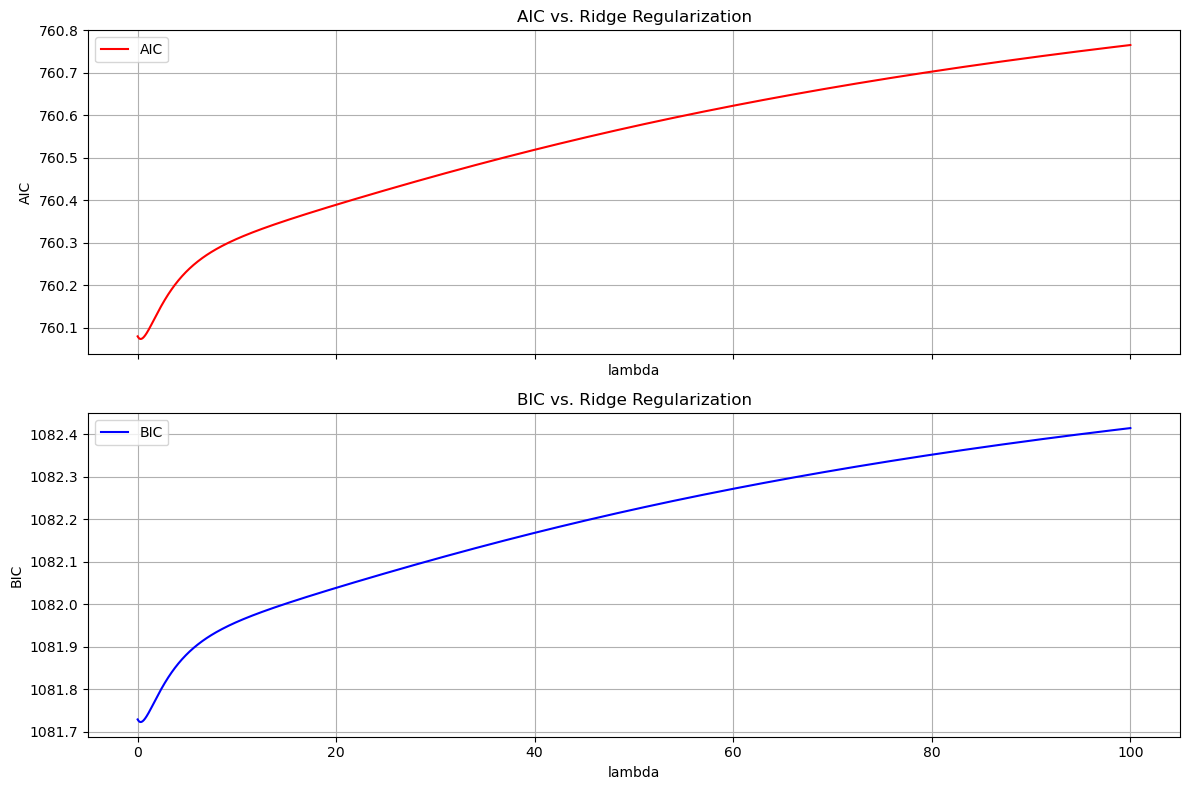

In [44]:
#stores data
coef=[]
aic_values=[]
bic_values=[]
lambdas = np.logspace(-2,2,1000)
np.insert(lambdas, 0, 0)

#loop to determine optimal lambda
for lam in lambdas:
    ridge=Ridge(alpha=lam)
    ridge.fit(X_train,Y_train)
    coef.append(ridge.coef_)
    
    Y_pred=ridge.predict(X_val)
    
    aic=calculate_aic(Y_val, Y_pred, len(ridge.coef_)+1)
    aic_values.append(aic)
    
    bic=calculate_bic(Y_val, Y_pred, len(ridge.coef_)+1)
    bic_values.append(bic)

# Create a subplot with two plots (coefficient paths and MSE values)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot the AIC values
ax1.plot(lambdas, aic_values , color='red', label='AIC')
ax1.set_xlabel('lambda')
ax1.set_ylabel('AIC')
ax1.set_title('AIC vs. Ridge Regularization')
ax1.legend()
ax1.grid()

# Plot the BIC values
ax2.plot(lambdas, bic_values , color='blue', label='BIC')
ax2.set_xlabel('lambda')
ax2.set_ylabel('BIC')
ax2.set_title('BIC vs. Ridge Regularization')
ax2.legend()
ax2.grid()
plt.tight_layout()
plt.show()

In [45]:
best_lambda_aic = round(lambdas[np.argmin(aic_values)], 2)
print(f"Best lambda based on validation set AIC: {best_lambda_aic}")
best_lambda_bic = round(lambdas[np.argmin(bic_values)], 2)
print(f"Best lambda based on validation set BIC: {best_lambda_aic}")

Best lambda based on validation set AIC: 0.31
Best lambda based on validation set BIC: 0.31


In [46]:
#reuse values from experiment
best_lambda = best_lambda_bic
ridge=Ridge(alpha=best_lambda)
#fit the model
ridge.fit(X_train, Y_train)
Y_pred = ridge.predict(X_val)
# Calculate AIC, BIC, RMSE and R2 on the testing set
r2_ridge = r2_score(Y_val, Y_pred)
rmse_ridge = root_mean_squared_error(Y_val, Y_pred)
aic_ridge = calculate_aic(Y_val, Y_pred, len(ridge.coef_) +1)
bic_ridge = calculate_bic(Y_val, Y_pred, len(ridge.coef_)+1)
print(f"The R-squared value for ridge is {r2_ridge:.2f}.")
print(f"The RMSE value for ridge is {rmse_ridge:.2f}.")
print(f"The AIC value for ridge is {aic_ridge:.2f}.")
print(f"The BIC value for ridge is {bic_ridge:.2f}.")

The r-squared value for ridge is 0.61.
The RMSE value for ridge is 3794.00.
The AIC value for ridge is 760.07.
The BIC value for ridge is 1081.72.


R-squared is exactly the same, while RMSE is slightly up. AIC and BIC are both much greater compared to SFS, indicating a worse model. The Bayes model is next and I find its theoretical basis appealing, based on updating existing information based on new information. The iterative updating model can produce good results for regression in some cases.

In [17]:
#Bayesian Linear Regression model specification
def log_likelihood(params, X, y):
    intercept = params[0]
    coeffs = params[1:]
    y_pred = intercept + np.dot(X, coeffs)
    y = np.array(y).ravel() # Converts DataFrame/2D array to 1D array
    residual = y - y_pred
    log_likelihood = -0.5 * np.sum(residual**2)
    return log_likelihood
def log_prior(params):
    # Assuming uninformative priors (flat priors)
    return 0.0
def log_posterior(params, X, y):
    return log_prior(params) + log_likelihood(params, X, y)

In [18]:
# Maximum A Posteriori (MAP) estimation
initial_guess = np.zeros(n_features + 1) # prior is 0
result = minimize(lambda params: -log_posterior(params, X_train, Y_train), initial_guess)
map_params = result.x
# Summary statistics of MAP estimated coefficients
print("MAP Estimated Coefficients:")
print(map_params)

MAP Estimated Coefficients:
[ 2393.27565182 -5754.74671396  2213.11556001  5707.30594647
   621.87116159  -838.4994569   1534.04314881 -3030.78861294
 -2328.48844768   154.31341826]


In [19]:
X_val_array=np.array(X_val)
Y_val_pred=map_params[0]
for i in range(n_features):
    Y_val_pred+=map_params[i+1]*X_val_array[:,i]
r2_bayes = r2_score(Y_val, Y_val_pred)
rmse_bayes = root_mean_squared_error(Y_val, Y_val_pred)
aic_bayes = calculate_aic(Y_val, Y_val_pred, 15)
bic_bayes = calculate_bic(Y_val, Y_val_pred, 15)
print(f"The R-squared value for Bayesian is {r2_bayes:.2f}.")
print(f"The RMSE value for Bayesian is {rmse_bayes:.2f}.")
print(f"The AIC value for Bayesian is {aic_bayes:.2f}.")
print(f"The BIC value for Bayesian is {bic_bayes:.2f}.")

The r-squared value for Bayesian is 0.67.
The RMSE value for Bayesian is 4799.67.
The AIC value for Bayesian is 788.47.
The BIC value for Bayesian is 1118.69.


That's a slightly better R-square but worse RMSE than our best model, and much worse AIC and BIC than the current best model, SFS. A decision tree is next. Lacking trainable parameters, I'm only reporting R-squared and RMSE as AIC and BIC don't apply. I'm using cross-validation to use the entire data set rather than just the one validation set.

In [20]:
depths = list(range(1, 20))
rmses = []
for depth in depths:
    tree_regress = DecisionTreeRegressor(random_state=0, max_depth=depth)
    rmse_cv = -np.mean(cross_val_score(tree_regress, X_train_val, Y_train_val, scoring='neg_root_mean_squared_error', cv=5))
    rmses.append(rmse_cv)
best_depth = depths[np.argmin(rmses)]
print(f"Best depth based on cross-validation RMSE: {best_depth}")

Best depth based on cross-validation RMSE: 7


The best tree depth is 7 deep based on minimal RMSE.

In [21]:
dt_regressor = DecisionTreeRegressor(random_state=0, max_depth=best_depth)
dt_regressor.fit(X_train, Y_train)
Y_pred=dt_regressor.predict(X_val)
r2_tree = r2_score(Y_val, Y_pred)
rmse_tree = root_mean_squared_error(Y_val, Y_pred)
print(f"The R-squared value for the tree model is {r2_tree:.2f}.")
print(f"The RMSE value for the tree model is {rmse_tree:.2f}.")

The r-squared value for the tree model is 0.69.
The RMSE value for the tree model is 4663.78.


This is the highest R-square value but also the second-highest RMSE value. I went back to a validation set for quantifying the results for more accurate comparison to other methods. AIC and BIC aren't meaningful for a tree so I did not calculate them. Let's see what a random forest can do, once again using cross-validation.

In [23]:
trees = list(range(1, 30))
rmses = []
for count in trees:
    tree_cat = RandomForestRegressor(n_estimators = count, random_state=0)
    rmse_cv = -np.mean(cross_val_score(tree_cat, X_train_val, Y_train_val_array, scoring='neg_root_mean_squared_error', cv=5))
    rmses.append(rmse_cv)

best_count = trees[np.argmin(rmses)]
print(f"Best number of trees for model based on validation accuracy: {best_count}")

Best number of trees for model based on validation accuracy: 13


In [24]:
#Create a Random Forest Classifier
rf_regressor = RandomForestRegressor(n_estimators=best_count, random_state=6)
# Fit the model to the training data
rf_regressor.fit(X_train, Y_train_array)
# Make predictions on the validation data
Y_pred = rf_regressor.predict(X_val)
rmse_forest = root_mean_squared_error(Y_val, Y_pred)
r2_forest = r2_score(Y_val, Y_pred)
print(f"The R-squared value for random forest is {r2_forest:.2f}.")
print(f"The RMSE value for random forest is {rmse_forest:.2f}.")

The r-squared value for ridge is 0.79.
The RMSE value for ridge is 3842.36.


The ensemble offers significantly better R-square and a similar RMSE to the best model so far. I would say this is the best yet. I once again did the final test, after tuning parameters, on a single validation set
for clearer comparison. The next model is the support vector regression. I will determine both lambda and the kernel by validation, using the default kernals available in sci-kit learn.

In [25]:
def svfunc(kernel, lam):
    svfun = SVR(kernel = kernel, C=lam)
    svfun.fit(X_train, Y_train_array)
    Y_pred=svfun.predict(X_val)
    return root_mean_squared_error(Y_pred, Y_val)

Best kernel: linear. Best lambda: 278.26. Best RMSE: 3537.92.


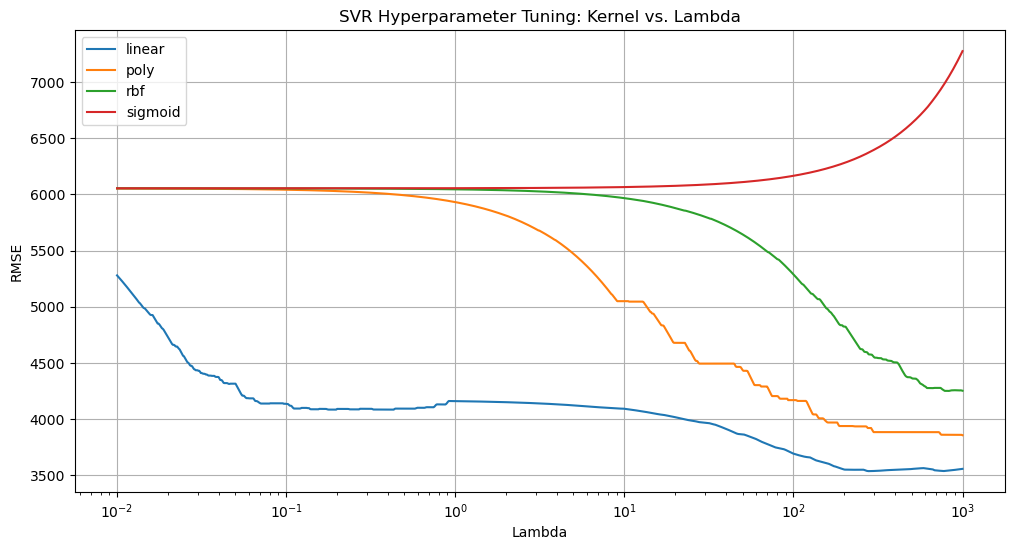

In [48]:
#trying many values over a range of orders of magnitude
lam_svr = np.logspace(-2,3,1000)
np.insert(lam_svr, 0, 0)
#the default kernels in sci-kit learn
kernels=['linear', 'poly', 'rbf', 'sigmoid']
#basic optimizing initializations
best_rmse = np.inf
best_kernel = None
best_lambda = None
results = []

#testing loop
for kern in kernels:
    for lam in lam_svr:
        rmse = svfunc(kern, lam)
        results.append((kern, lam, rmse))
      
        #update best parameters if RMSE improves
        if rmse < best_rmse:
            best_rmse = rmse
            best_kernel = kern
            best_lambda = lam
        
print(f"Best kernel: {best_kernel}. Best lambda: {best_lambda:.2f}. Best RMSE: {best_rmse:.2f}.")
results = np.array(results, dtype=object)
plt.figure(figsize=(12, 6))
# Plot RMSE curves for each kernel
for kern in kernels:
    subset = results[results[:, 0] == kern] # Filter by kernel
    plt.plot(subset[:, 1].astype(float), subset[:, 2].astype(float), label=kern)

plt.xscale("log") # Log scale for lambda
plt.xlabel("Lambda")
plt.ylabel("RMSE")
plt.title("SVR Hyperparameter Tuning: Kernel vs. Lambda"),
plt.legend()
plt.grid()
plt.show()

In [49]:
svreg = SVR(kernel = best_kernel, C=best_lambda)
svreg.fit(X_train, Y_train_array)
Y_pred=svreg.predict(X_val)
r2_svr = r2_score(Y_val, Y_pred)
rmse_svr = root_mean_squared_error(Y_val, Y_pred)
aic_svr = calculate_aic(Y_val, Y_pred, 15)
bic_svr = calculate_bic(Y_val, Y_pred, 15)
print(f"The R-squared value for SVR is {r2_svr:.2f}.")
print(f"The RMSE value for SVR is {rmse_svr:.2f}.")
print(f"The AIC value for SVR is {aic_svr:.2f}.")
print(f"The BIC value for SVR is {bic_svr:.2f}.")

The r-squared value for SVR is 0.66.
The RMSE value for SVR is 3537.92.
The AIC value for SVR is 762.12.
The BIC value for SVR is 1092.34.


This is an intermediate R-squared value and the best RMSE value so far. AIC and BIC are still up compared to SFS, likely due to the increased number of parameters in the model. Next up is a small neural network, designed with just two hidden layers to try to prevent overfitting. Early stopping was instituted so that overtraining does not occur. I have to modify the data to start.

In [63]:
X_train_nn = torch.tensor(np.array(X_train), dtype=torch.float32)
Y_train_nn = torch.tensor(np.array(scaler.fit_transform(Y_train)), dtype=torch.float32)
Y_train_nn_reg = np.array(Y_train)
X_val_nn = torch.tensor(np.array(X_val), dtype=torch.float32)
Y_val_nn = torch.tensor(np.array(scaler.fit_transform(Y_val)), dtype=torch.float32)
Y_val_nn_reg = np.array(Y_val)
X_test_nn = torch.tensor(np.array(X_test), dtype=torch.float32)
Y_test_nn = torch.tensor(np.array(scaler.fit_transform(Y_test)), dtype=torch.float32)
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

This is the function for tuning hyperparameters for the neural network. Two hidden layers are used and the layer width is the tuning parameter.

In [64]:
def number_neurons_function(layer_width):
    """
    Train a 2-hidden-layer neural network with given width.
    Returns best validation RMSE for use in hyperparameter tuning.
    """
    best_rmse = np.inf
    best_weights = None
    epochs_no_improve = 0
    patience = 250
    n_epochs = 10000
    batch_size = 100
    batch_start = torch.arange(0, len(X_train_nn), batch_size)

    # Define model
    modelNN = nn.Sequential(
        nn.Linear(n_features, layer_width),
        nn.ReLU(),
        nn.Linear(layer_width, layer_width),
        nn.ReLU(),
        nn.Linear(layer_width, 1)
    )

    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(modelNN.parameters(), lr=0.001, weight_decay=1e-5)

    for epoch in range(n_epochs):
        modelNN.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                X_batch = X_train_nn[start:start+batch_size]
                Y_batch = Y_train_nn[start:start+batch_size]

                Y_pred = modelNN(X_batch)
                loss = loss_fn(Y_pred, Y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                bar.set_postfix(mse=float(loss))

        # Validation RMSE
        modelNN.eval()
        with torch.no_grad():
            Y_pred_val = modelNN(X_val_nn)
            Y_pred_reverse_val = scaler.inverse_transform(Y_pred_val.numpy()).reshape(-1, 1)
            rmse_val = root_mean_squared_error(Y_val_nn_reg, Y_pred_reverse_val)

        if rmse_val < best_rmse:
            best_rmse = rmse_val
            best_weights = copy.deepcopy(modelNN.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    return best_rmse, best_weights


Tuning number of neurons:
Testing 2 neurons...
Testing 3 neurons...
Testing 4 neurons...
Testing 5 neurons...
Testing 6 neurons...
Testing 7 neurons...
Testing 8 neurons...
Testing 9 neurons...
Testing 10 neurons...
Testing 11 neurons...
Testing 12 neurons...
Testing 13 neurons...
Testing 14 neurons...
Testing 15 neurons...
Testing 16 neurons...
Testing 17 neurons...
Testing 18 neurons...
Testing 19 neurons...
Testing 20 neurons...
Testing 21 neurons...
Testing 22 neurons...
Testing 23 neurons...
Testing 24 neurons...
Testing 25 neurons...
Testing 26 neurons...
Testing 27 neurons...
Testing 28 neurons...
Testing 29 neurons...
Testing 30 neurons...
Testing 31 neurons...
Testing 32 neurons...

Optimal number of neurons: 30


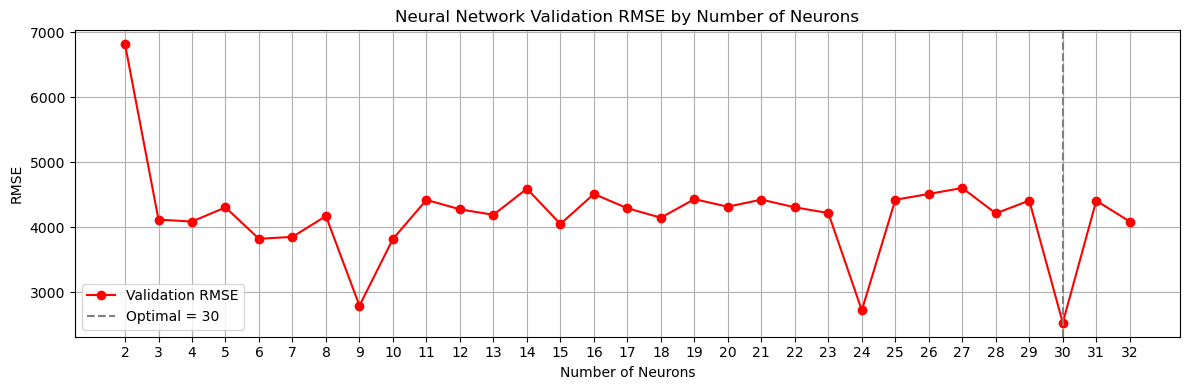

In [65]:
# Range of neurons to test
neuron_range = range(2, 33)
rmses_nn = []
best_weights = []

print("Tuning number of neurons:")
for neurons in neuron_range:
    print(f"Testing {neurons} neurons...")
    rmse, best_weight = number_neurons_function(neurons)
    rmses_nn.append(rmse) 
    best_weights.append(best_weight)
    
# Find optimal number of neurons
optimal_neurons = neuron_range[np.argmin(rmses_nn)]
print(f"\nOptimal number of neurons: {optimal_neurons}")

# Plot RMSE vs. number of neurons
plt.figure(figsize=(12, 4))
plt.plot(neuron_range, rmses_nn, marker='o', color='red', label='Validation RMSE')
plt.axvline(optimal_neurons, linestyle='--', color='gray', label=f'Optimal = {optimal_neurons}')
plt.xlabel("Number of Neurons")
plt.ylabel("RMSE")
plt.title("Neural Network Validation RMSE by Number of Neurons")
plt.xticks(neuron_range)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [67]:
best_weight = best_weights[np.argmin(rmses_nn)]
best_rmse = min(rmses_nn)

modelNN2 = nn.Sequential(
    nn.Linear(n_features, optimal_neurons),
    nn.ReLU(),
    nn.Linear(optimal_neurons, optimal_neurons),
    nn.ReLU(),
    nn.Linear(optimal_neurons, 1)
)
modelNN2.load_state_dict(best_weight)
modelNN2.eval()
with torch.no_grad():
    Y_pred_val = modelNN2(X_val_nn)
    Y_pred_reverse_val = scaler.inverse_transform(Y_pred_val.numpy()).reshape(-1, 1)
    rmse_val = root_mean_squared_error(Y_val_nn_reg, Y_pred_reverse_val)
    r2_val = r2_score(Y_val_nn_reg, Y_pred_reverse_val)

# Final results
print(f"The R-squared value for the neural network is {r2_val:.2f}.")
print(f"The RMSE value for the neural network is {rmse_val:.2f}.")


The R-squared value for the neural network is 0.82.
The RMSE value for the neural network is 2533.05.


This is an excellent result with the best R-squared value and, by far, the lowest RMSE, using the optimal 30 neurons with one hidden layer.

In [68]:
initial_guess = np.zeros(n_features + 1) # prior is 0
result_test = minimize(lambda params: -log_posterior(params, X_train_val, Y_train_val), initial_guess)
map_params = result_test.x

In [75]:
# Define model with optimal architecture
num_neur = 30
modelNNTest = nn.Sequential(
    nn.Linear(n_features, num_neur),
    nn.ReLU(),
    nn.Linear(num_neur, num_neur),
    nn.ReLU(),
    nn.Linear(num_neur, 1)
)

# Load pretrained weights
modelNNTest.load_state_dict(best_weight)
modelNNTest.eval()

# Prepare test data
X_test_nn = torch.tensor(np.array(X_test), dtype=torch.float32)
Y_test_nn_reg = np.array(Y_test)

# Predict and inverse-transform
with torch.no_grad():
    Y_pred_test = modelNNTest(X_test_nn)
    Y_pred_reverse_test = scaler.inverse_transform(Y_pred_test.numpy()).reshape(-1, 1)

# Evaluate
rmse_test = root_mean_squared_error(Y_test_nn_reg, Y_pred_reverse_test)
r2_test = r2_score(Y_test_nn_reg, Y_pred_reverse_test)

# Report
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test R²: {r2_test:.2f}")


Test RMSE: 4598.87
Test R²: 0.73


In [76]:
rmse_uninform=root_mean_squared_error(np.ones(len(X_test))*np.mean(Y_train_val),Y_test)
print(f"The RMSE associated with the uninformative model is {rmse_uninform:.0f}.")
basicLinear=LinearRegression()
basicLinear.fit(X_train_val, Y_train_val)
# Basic Linear Regression
Y_basic = basicLinear.predict(X_test)
rmse_basic = root_mean_squared_error(Y_test, Y_basic)
print(f"The RMSE associated with the basic linear model is {rmse_basic:.0f}.")

# Sequential Feature Selector (SFS) with Linear Regression
X_train_val_selected = sfs.transform(X_train_val)
modelSFS.fit(X_train_val_selected, Y_train_val)
X_test_selected = sfs.transform(X_test)
YSFS_pred = modelSFS.predict(X_test_selected)
rmse_sfs_test = root_mean_squared_error(Y_test, YSFS_pred)
print(f"The RMSE associated with sequential feature selection is {rmse_sfs_test:.0f}.")

# Ridge Regression
ridge_test = Ridge(alpha=0.31)
ridge_test.fit(X_train_val, Y_train_val)
YRR = ridge_test.predict(X_test)
rmse_rr_test = root_mean_squared_error(Y_test, YRR)
print(f"The RMSE associated with ridge linear regression is {rmse_rr_test:.0f}.")

# Bayesian Inference Prediction
YBayes_pred = map_params[0]
for i in range(n_features):
    YBayes_pred += map_params[i + 1] * X_test_array[:, i]
rmse_bayes_test = root_mean_squared_error(Y_test, YBayes_pred)
print(f"The RMSE associated with Bayesian inference is {rmse_bayes_test:.0f}.")

# Decision Tree Regressor
dt_regressor_test = DecisionTreeRegressor(random_state=6, max_depth=7)
dt_regressor_test.fit(X_train_val, Y_train_val)
Y_dt_pred = dt_regressor_test.predict(X_test)
rmse_dt = root_mean_squared_error(Y_test, Y_dt_pred)
print(f"The RMSE associated with the decision tree is {rmse_dt:.0f}.")

# Random Forest Regressor
rf_regressor_test = RandomForestRegressor(n_estimators=13, random_state=6)
rf_regressor_test.fit(X_train_val, Y_train_val_array)
Y_rf_pred = rf_regressor_test.predict(X_test)
rmse_rf = root_mean_squared_error(Y_test, Y_rf_pred)
print(f"The RMSE associated with the random forest is {rmse_rf:.0f}.")

# Support Vector Regression
svregtest = SVR(kernel='linear', C=278.26)
svregtest.fit(X_train_val, Y_train_val_array)
YSVR = svregtest.predict(X_test)
rmse_svr = root_mean_squared_error(Y_test, YSVR)
print(f"The RMSE associated with the support vector regression is {rmse_svr:.0f}.")

# Neural Network
modelNNTest.eval()
Y_pred_test = modelNNTest(X_test_nn)
Y_pred_reverse_test = scaler.inverse_transform(Y_pred_test.detach().numpy()).reshape(-1, 1)
rmse_nn = root_mean_squared_error(Y_test_nn_reg, Y_pred_reverse_test)
print(f"The RMSE associated with the neural network is {rmse_nn:.0f}.")


The RMSE associated with the uninformative model is 8849.
The RMSE associated with the basic linear model is 4172.
The RMSE associated with sequential feature selection is 4167.
The RMSE associated with ridge linear regression is 4155.
The RMSE associated with Bayesian inference is 4172.
The RMSE associated with the decision tree is 2604.
The RMSE associated with the random forest is 2588.
The RMSE associated with the support vector regression is 5338.
The RMSE associated with the neural network is 4599.


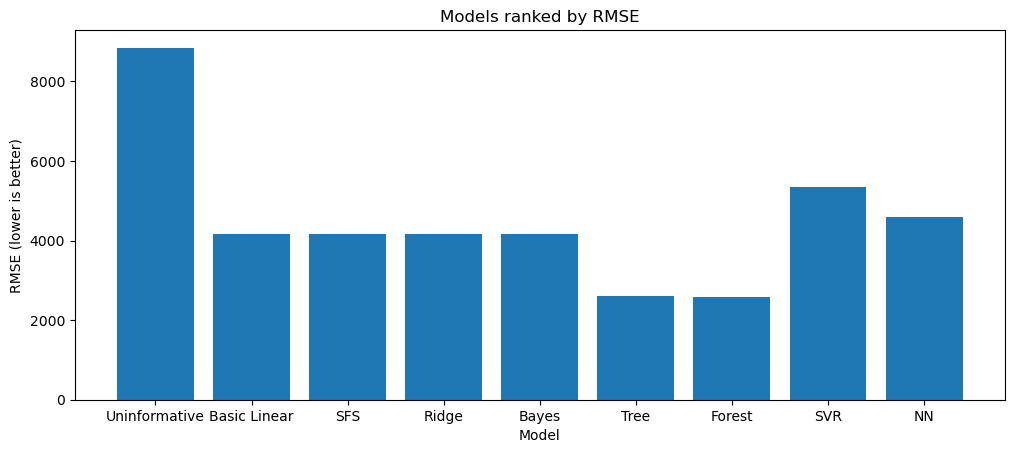

In [78]:
models=["Uninformative", "Basic Linear", "SFS", "Ridge","Bayes","Tree","Forest", "SVR", "NN"]
model_rmse=[rmse_uninform, rmse_basic, rmse_sfs_test, rmse_rr_test, rmse_bayes_test, rmse_dt, rmse_rf, rmse_svr, rmse_nn]
results = plt.figure()
results.set_figwidth(12)
plt.bar(models, model_rmse)
plt.xlabel("Model")
plt.ylabel("RMSE (lower is better)")
plt.title("Models ranked by RMSE")
plt.show()

We can see that all of the models handily outperformed the uninformative model, indicating
that the data has some trend to be learned. Interestingly, the basic linear regression model
performed admirably for being four lines of code. The decision tree and the support vector
regression were particularly bad, suggesting that the decision tree possibly overfit while the
SVR may not be appropriate for the simple relationships that seem evident in the data. The
random forest was the best model by a little bit and I will analyze it a little further.

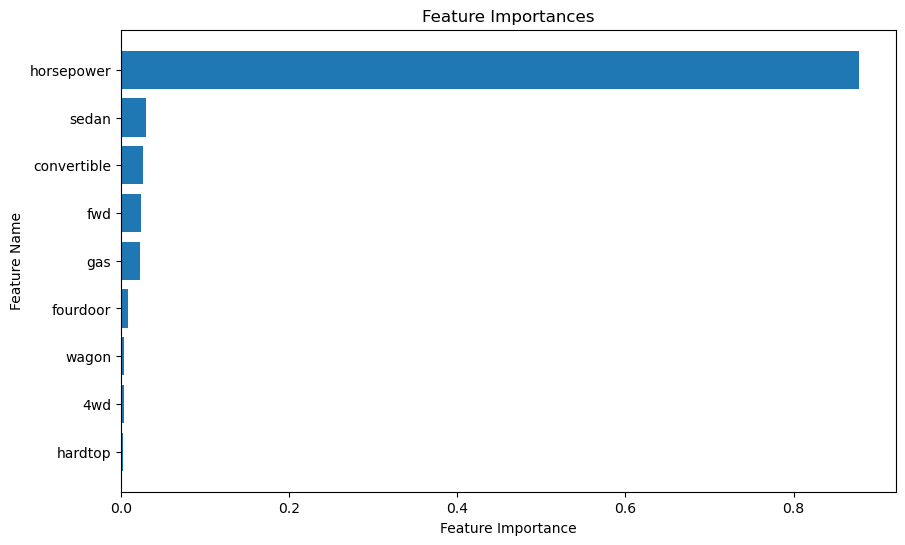

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance(model, names, threshold=None):
    if not hasattr(model, "feature_importances_"):
        raise AttributeError("The provided model does not have feature_importances_.")

    # Create DataFrame of feature importances
    feature_importance_df = pd.DataFrame({
        'feature': names,
        'feature_importance': model.feature_importances_
    }).set_index('feature').sort_values('feature_importance', ascending=False)

    # Apply threshold if specified
    if threshold is not None:
        feature_importance_df = feature_importance_df[
            feature_importance_df['feature_importance'] >= threshold
        ]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df.index, feature_importance_df['feature_importance'])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()  # Highest importance at top
    plt.show()

plot_feature_importance(rf_regressor_test, X_train_val.columns)

For the final random forest model, horsepower is overwhelmingly the most important feature
in predicting the car price and not really much else matters. Just as a final check on that, I'm
constructing a simple linear regression based on horsepower alone.

In [83]:
X_train_horsepower = X_train_val['horsepower'].values.reshape(-1, 1)
X_test_horsepower = X_test['horsepower'].values.reshape(-1, 1)
hp_linear=LinearRegression()
hp_linear.fit(X_train_horsepower, Y_train_val)
Y_hp=hp_linear.predict(X_test_horsepower)
rmse_hp=root_mean_squared_error(Y_hp, Y_test)
print(f"The RMSE associated with the basic linear model is {rmse_hp:.0f}.")

The RMSE associated with the basic linear model is 5103.


This is a reasonable result, beating out support vector regression, confirming that horsepower does indeed explain much of the model. My modeling suggeststhat a random forest for regression is the optimal model for predicting the price of carsbased on this dataset. The feature of maximal importance is horsepower, with no othervariables having much significance to this model.